In [55]:
import os
import gc
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patches as patches
import numpy as np
import cv2
import pandas as pd
import seaborn as sns
from utils.helper import Helper
from tqdm.notebook import tqdm
from matplotlib import cm, gridspec
import matplotlib as mpl
import matplotlib.patches as mpatches
import gradcamutils

from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

SMALL_SIZE = 12
MEDIUM_SIZE = 22
BIGGER_SIZE = 27

plt.style.use('ggplot')

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=35)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

## Sample GradCAM and Guided GradCAM

In [125]:
def scale_img(img, qmin=0, qmax=255):
    max_val = img.max()
    min_val = img.min()
    scaled_img = ((img - min_val)/(max_val - min_val)) * (qmax - qmin)
    return scaled_img
def visualize(sm, cmap, alpha=0.4):
    x = cv2.imread("topo_viz.png")
    x = cv2.resize(x, (400,400))
    sm = cv2.resize(sm, (400,400))
    sm = gradcamutils.deprocess_image(sm)
    
    plt.imshow(sm, cmap=cmap)
    plt.imshow(x, alpha=alpha)
    plt.axis('off')
    
def show_kernel_ch_pos(pos, kernel, ggbp, ax, cmap='jet'):
    topo = cv2.imread("topo_viz.png", cv2.IMREAD_COLOR)
    topo = cv2.resize(topo, (400,400))
    ggbp = cv2.resize(ggbp, (400,400))
    ggbp = gradcamutils.deprocess_image(ggbp)
    
    m,n = kernel

    
    
    ax.imshow(ggbp, cmap=cmap)
    ax.imshow(topo, alpha=0.8)
    
    ax.axis('off')
    for p in pos:
        x = p[0]
        y = p[1]
        b_box = patches.Rectangle([y-m//2,x-n//2], int(m * 1.5), int(n * 1.5), facecolor='none', 
                                  edgecolor='#212121', linewidth=3, alpha=0.5)
        ax.add_patch(b_box)


In [3]:
sm_spsm_10_slow = np.load('saliency_maps/slow/SPSM-10.npy')
sm_spsm_10_med = np.load('saliency_maps/med/SPSM-10.npy')
sm_spsm_10_fast = np.load('saliency_maps/fast/SPSM-10.npy')

ggbp_spsm_10_slow = np.load('guided_gradcams/slow/SPSM-10.npy')
ggbp_spsm_10_med = np.load('guided_gradcams/med/SPSM-10.npy')
ggbp_spsm_10_fast = np.load('guided_gradcams/fast/SPSM-10.npy')

pos = np.load('channel_pos_400x400.npy')

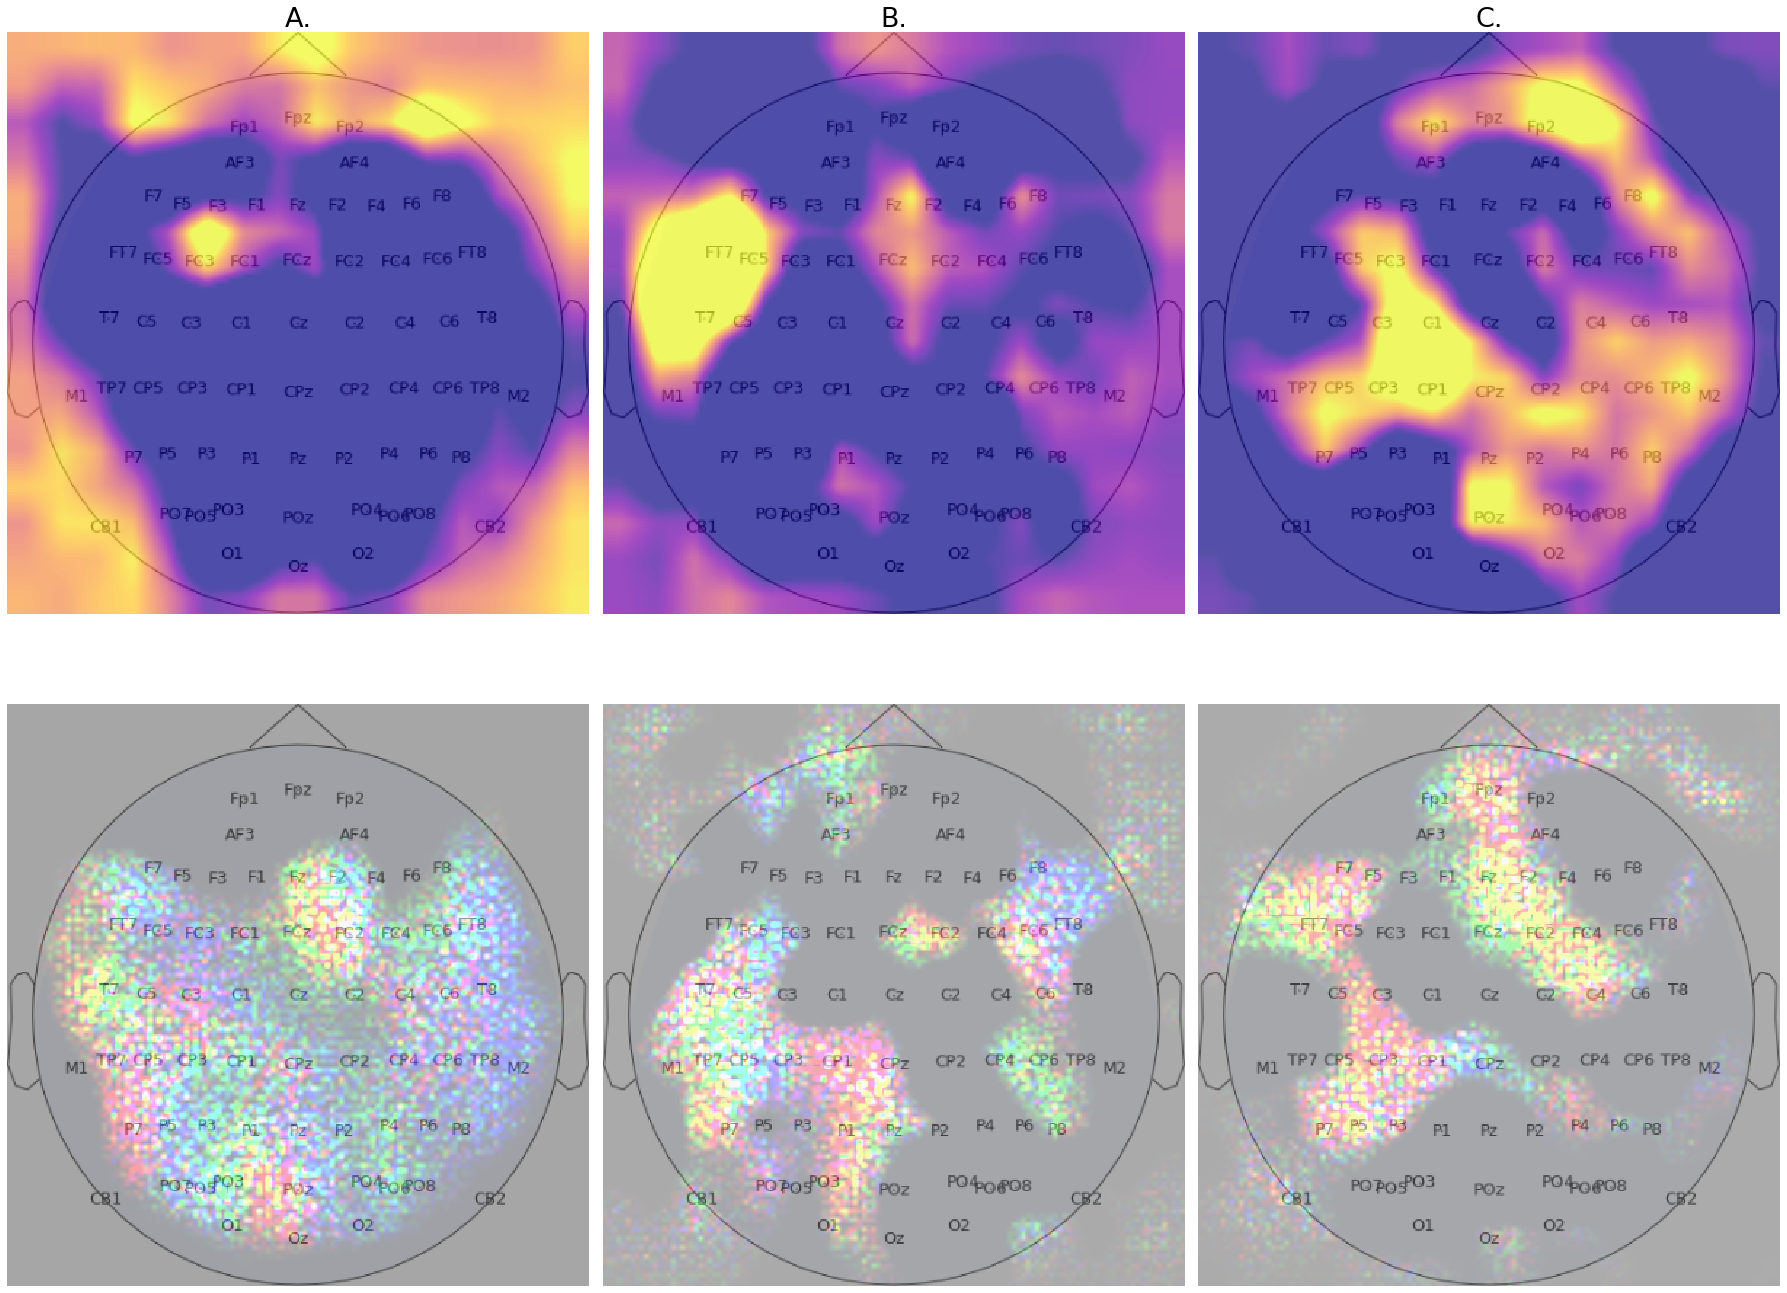

In [155]:
plt.figure(figsize=(25,20))
plt.subplot(231)
plt.title('A.')
visualize(sm_spsm_10_fast[0], 'plasma',0.3)
plt.subplot(232)
plt.title('B.')
visualize(sm_spsm_10_fast[1], 'plasma',0.3)
plt.subplot(233)
plt.title('C.')
visualize(sm_spsm_10_fast[2], 'plasma',0.3)
plt.subplot(234)
visualize(ggbp_spsm_10_fast[0], 'jet', 0.45)
plt.subplot(235)
visualize(ggbp_spsm_10_fast[1], 'jet', 0.45)
plt.subplot(236)
visualize(ggbp_spsm_10_fast[2], 'jet', 0.45)
plt.tight_layout(pad=0.5)

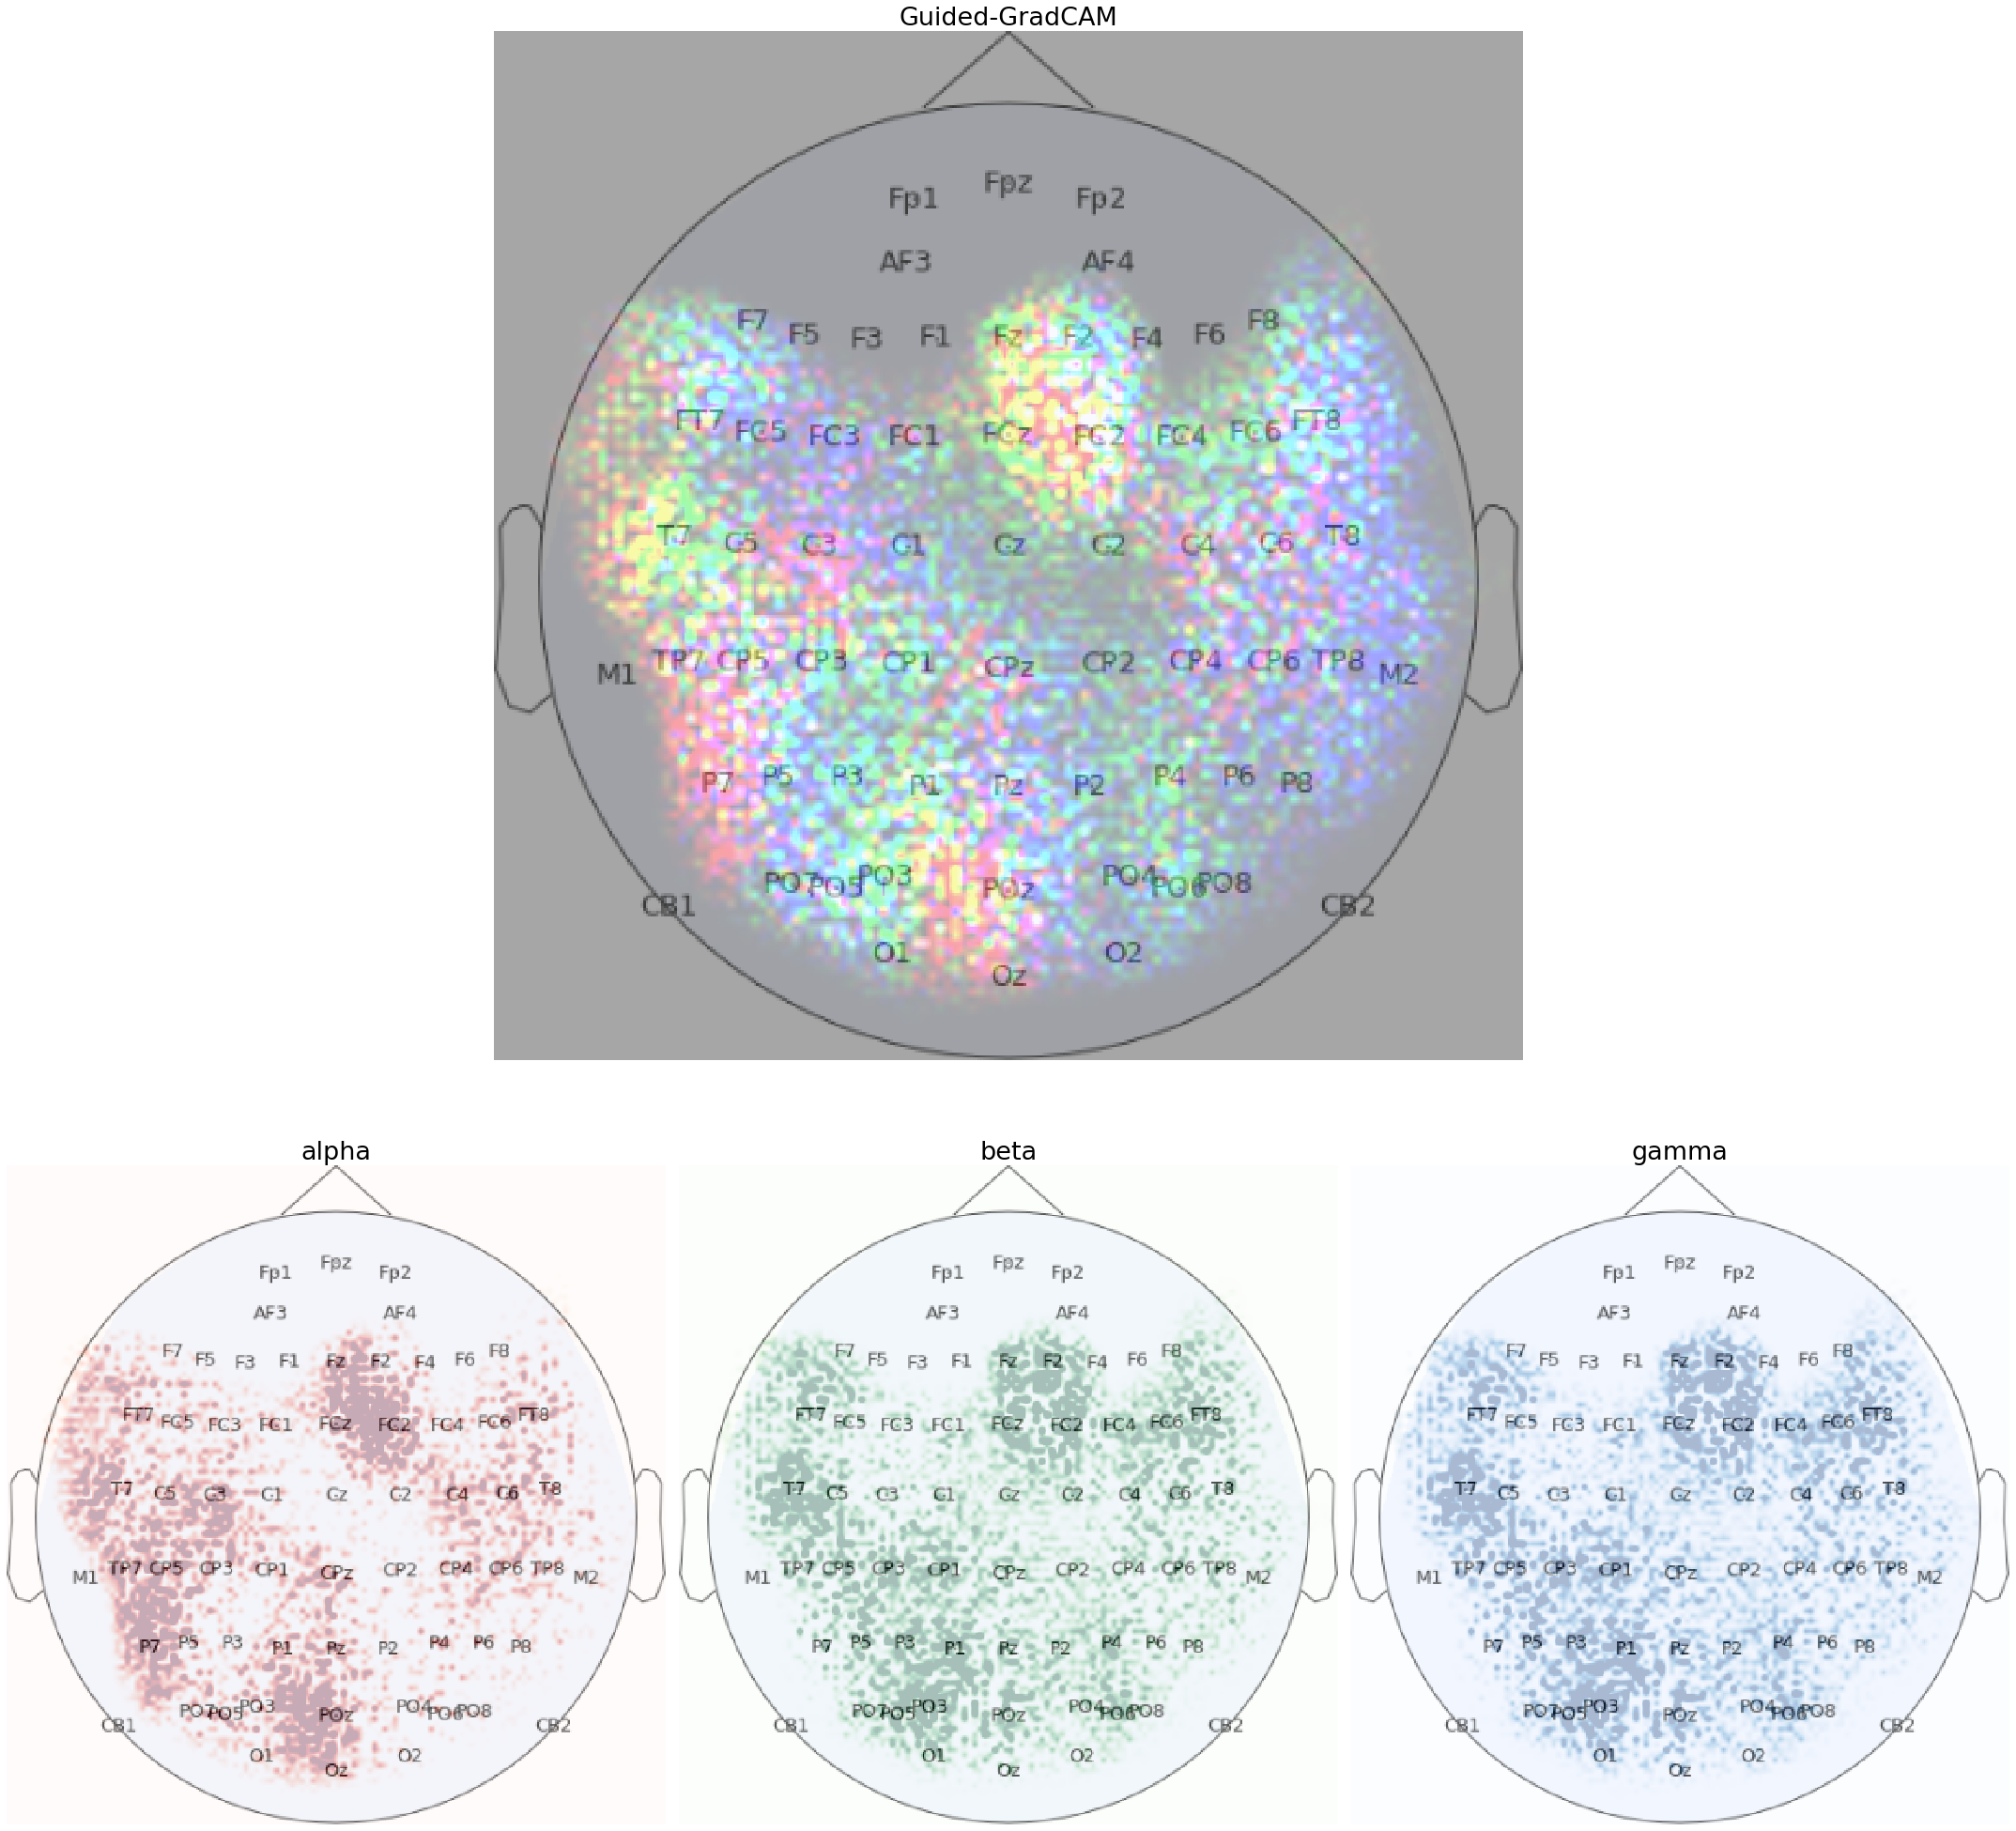

In [154]:
plt.figure(figsize=(30,30))
gs = gridspec.GridSpec(2, 3)

plt.subplot(gs[0, :])

plt.title('Guided-GradCAM')
visualize(ggbp_spsm_10_fast[0], 'jet', 0.45)

plt.subplot(gs[1, 0])

alpha = ggbp_spsm_10_fast[0, :, :, 0]

plt.title('alpha')
visualize(alpha, 'Reds', 0.7)

plt.subplot(gs[1, 1])

beta = ggbp_spsm_10_fast[0, :, :, 1]

plt.title('beta')
visualize(beta, 'Greens', 0.7)

plt.subplot(gs[1, 2])

gamma = ggbp_spsm_10_fast[0, :, :, 1]

plt.title('gamma')
visualize(gamma, 'Blues', 0.7)

plt.tight_layout(pad=0.5)

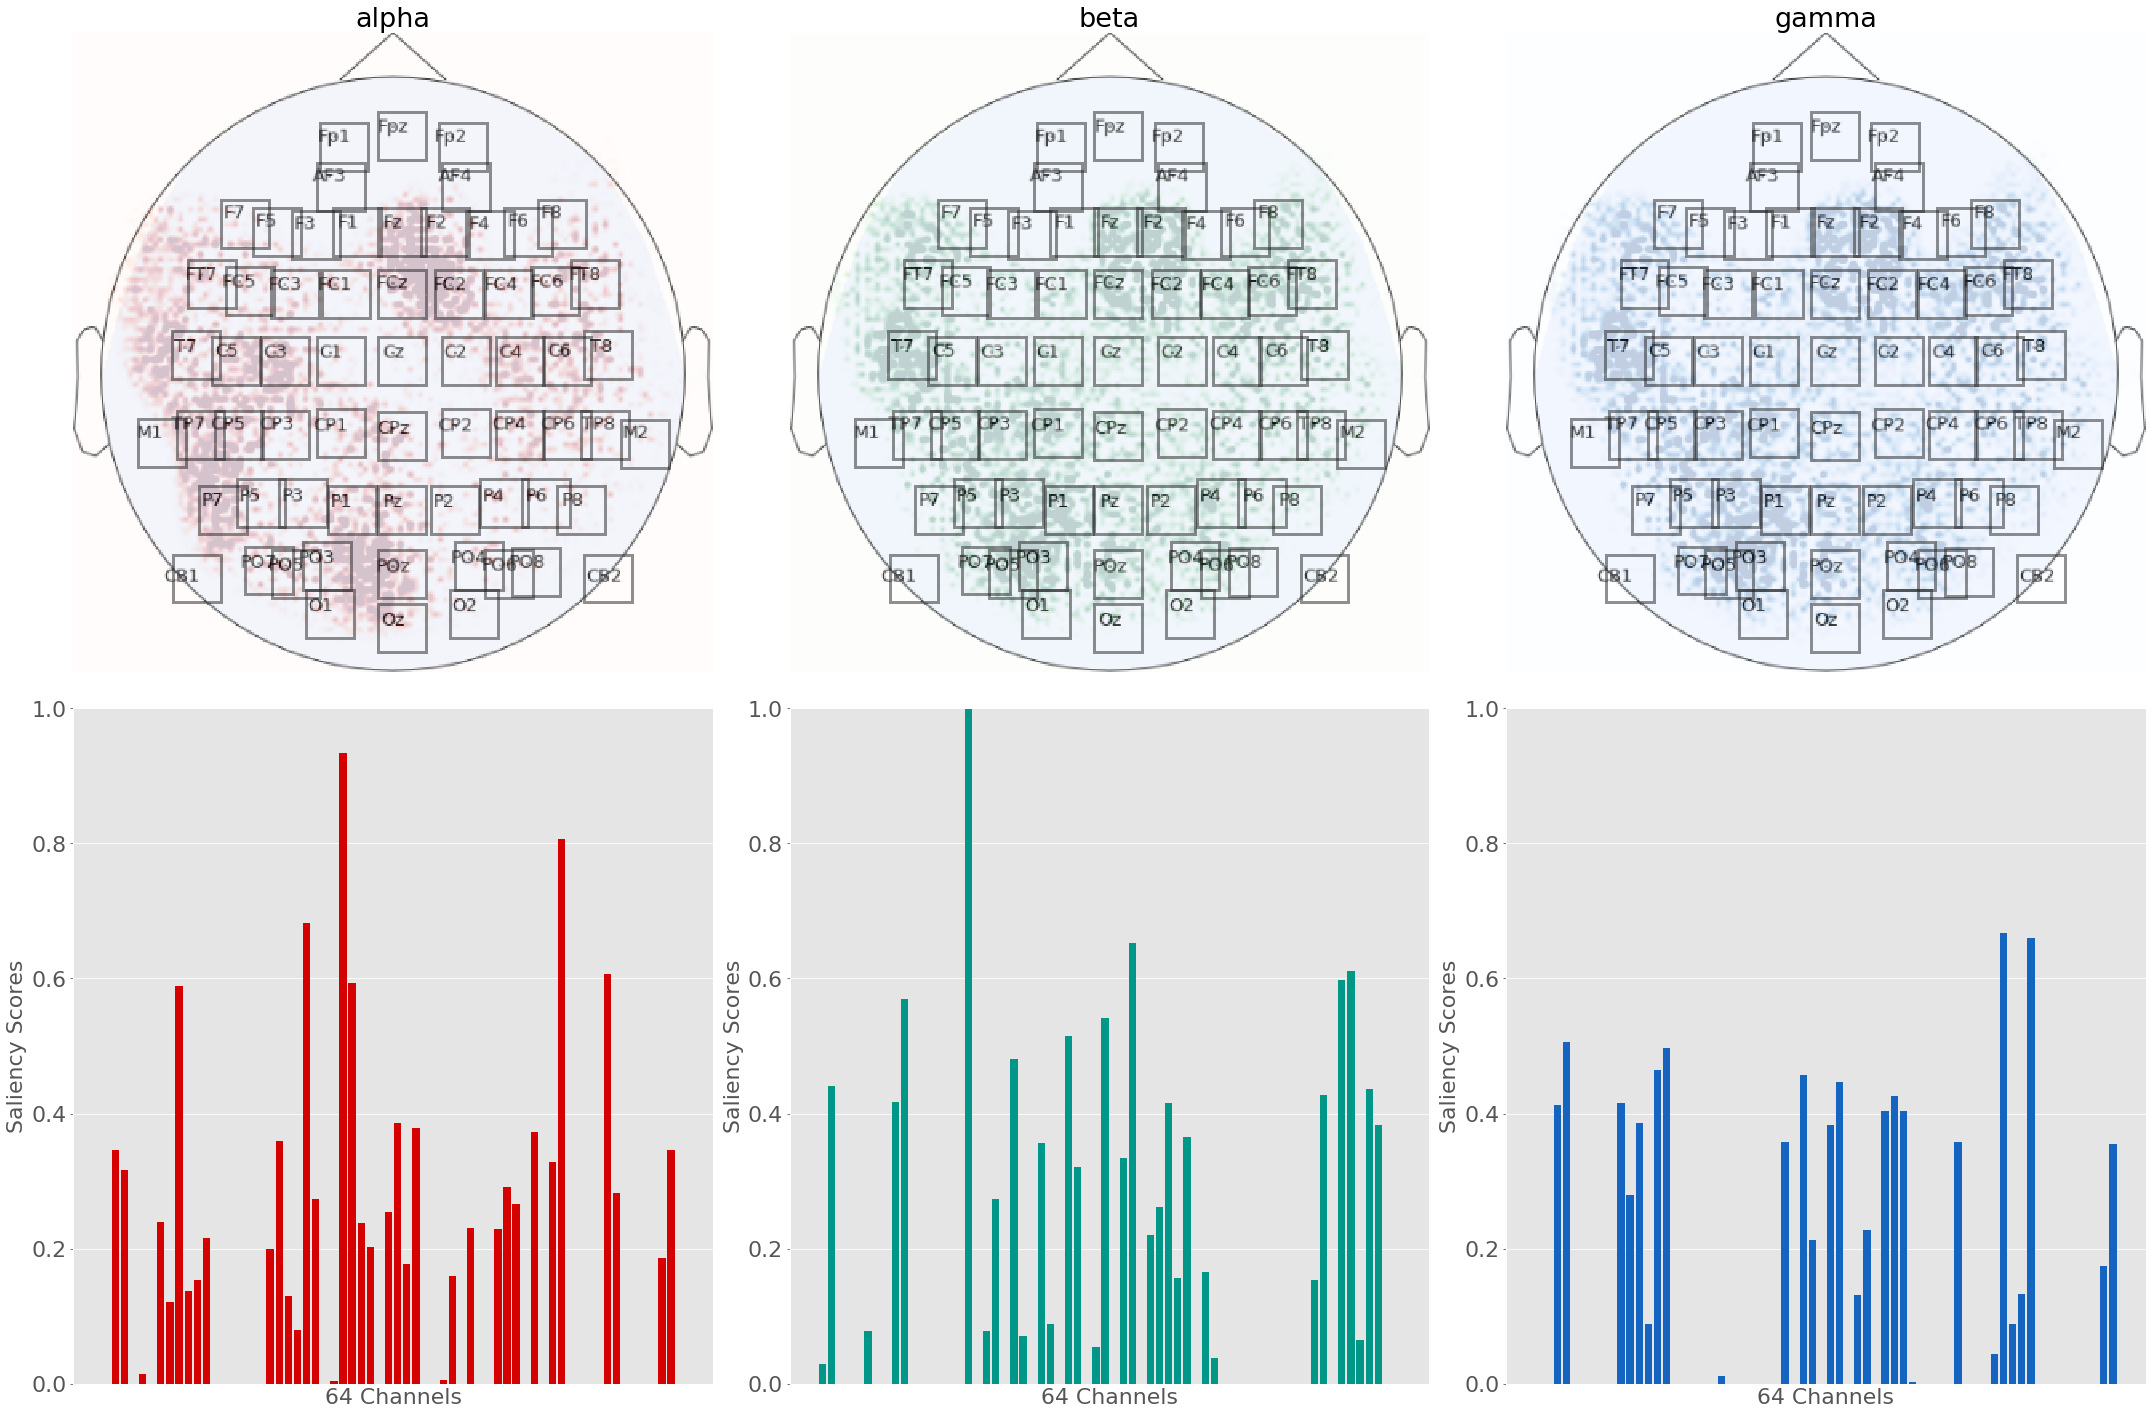

In [152]:
scs = scale_img(np.load('saliency_scores/fast/SPSM-10-20x20.npy')[0], 0, 1)

fig, axes = plt.subplots(2, 3, figsize=(30,20))
sample_ggbp = [alpha, beta, gamma]
cmaps = ['Reds', 'Greens', 'Blues']
titles = ['alpha', 'beta', 'gamma']
alpha_sc, beta_sc, gamma_sc = scs[0:64], scs[64:128], scs[128:192]
sample_sc = [alpha_sc, beta_sc, gamma_sc]
for i, ggbp in enumerate(sample_ggbp):
    axes[0,i].set_title(titles[i])
    show_kernel_ch_pos(pos, (20, 20), ggbp, axes[0,i], cmaps[i])

colors = ["#d50000", "#009688", "#1565C0"]
for i, sc in enumerate(sample_sc):
    axes[1,i].set_ylim([0,1])
    axes[1,i].set_ylabel('Saliency Scores')
    axes[1,i].set_xlabel('64 Channels')
    axes[1,i].set_xticks([])
    axes[1,i].bar(range(64), sc, color=colors[i])
    
plt.tight_layout(pad=0.4)

## Confusion Matrix for all SPSMs

In [2]:
def get_cfm_acc(X_it, y_true, model):
    
    y_pred = np.argmax(model.predict_generator(X_it), axis=1)
    acc = accuracy_score(y_true, y_pred)
    return confusion_matrix(y_true, y_pred, normalize='pred'), acc, y_pred

def viz_cfm(cfm, title, ax):
    ax.set_title(title)
    
    sns.heatmap(cfm, annot=True, fmt='.2g', cmap=cm.Blues, ax = ax, cbar=False)
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.xaxis.set_ticklabels(['slow', 'fast', 'medium']); ax.yaxis.set_ticklabels(['slow', 'fast', 'medium']);

In [3]:
h = Helper("data/topomaps_RT_50_w_sub/train/combined/", "data/topomaps_RT_50_w_sub/test/combined/", None, None)

train_it, test_it = h.construct_data_generator(target_size=(128,128), shuffle=False)

Found 46893 images belonging to 3 classes.
Found 15632 images belonging to 3 classes.


In [4]:
model_dir = "top_10_spsm"
model_ids = ["SPSM-{}".format(id + 1) for id in range(10)]

y_true = h.y_true

y_trues = np.tile(y_true, 10)
y_preds = []
cfm_dict = dict()
acc_dict = dict()

for id in tqdm(model_ids):
    model_path = os.path.join(model_dir, "{}.h5".format(id))
    
    K.clear_session()
    
    model = load_model(model_path)
    cfm_dict[id], acc_dict[id], y_pred = get_cfm_acc(test_it, y_true, model)
    y_preds = np.append(y_preds, y_pred)

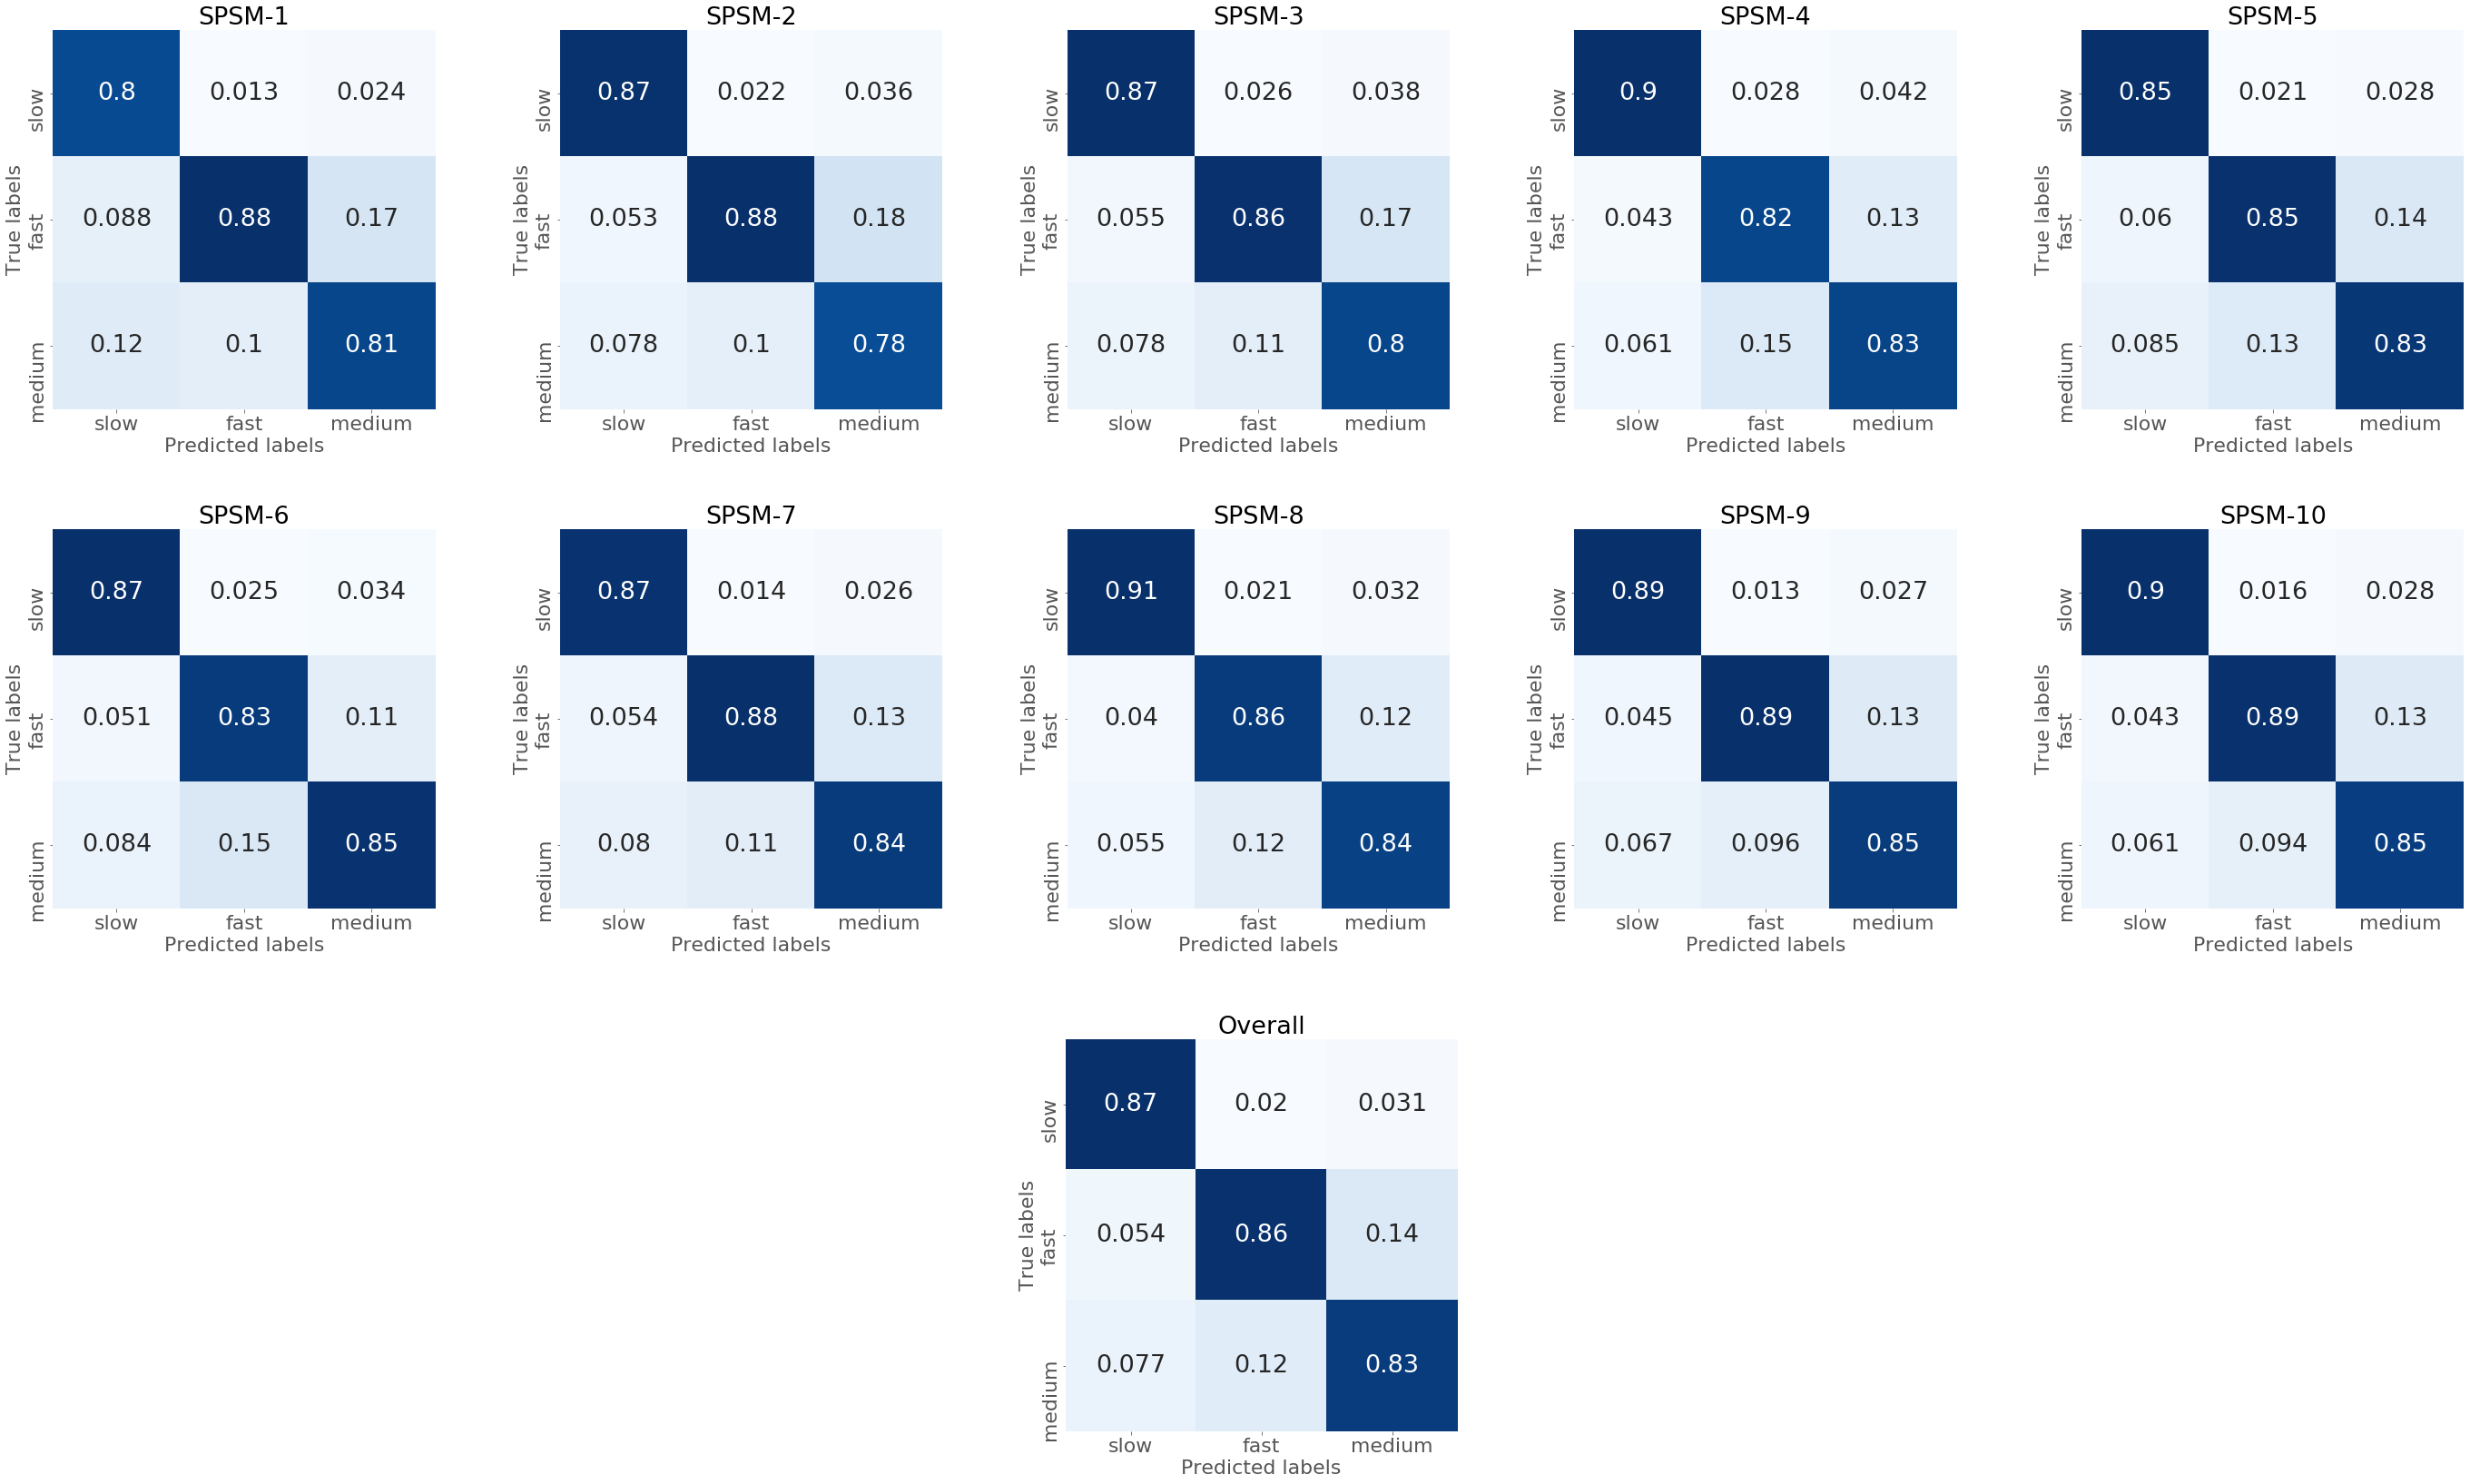

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(40, 20))
axes = axes.flatten()

for i,id in enumerate(cfm_dict):
    viz_cfm(cfm_dict[id], id, axes[i])
    
fig.tight_layout(pad=3.2)
overall_cfm = confusion_matrix(y_trues, y_preds, normalize='pred')

fig.subplots_adjust(bottom=0.25)
ax = fig.add_axes([0.435, -0.15, 0.15, 0.30])

viz_cfm(overall_cfm, "Overall", ax)

In [6]:
def normalize(img):
    img = img.astype(np.float64)
    max_val = img.max()
    min_val = img.min()
    img = (img - min_val)/(max_val - min_val)
    return img

def show_salient_ch(pos, ax, colors, kernel = (60,60)):
    topo = cv2.imread("topo_viz.png", cv2.IMREAD_GRAYSCALE)
    topo = cv2.resize(topo, (400,400))
    m,n = kernel

    ax.imshow(topo, cmap='gray')
    for p, c in zip(pos,colors):
        x = p[0]
        y = p[1]
        b_box = patches.Rectangle([y-m//4,x-n//4], m//2, n//2, facecolor=c, edgecolor=c, linewidth=5)
        ax.add_patch(b_box)
        
def get_ch_names(indexes, channels):

    return channels[indexes]

In [62]:
def viz_spatial_saliency(sv, pos, title, channels, ax, r=10):

    mean_s_ch = normalize(np.mean(sv, axis=0))
    
    top_i = np.argsort(mean_s_ch)[::-1][:r]

    top_ch_i = np.where((top_i >=64) & (top_i < 128), top_i - 64, top_i)
    top_ch_i = np.where((top_ch_i >= 128) & (top_ch_i < 192), top_ch_i - 128, top_ch_i)
    
    print("{} : {}".format(title, get_ch_names(top_ch_i, channels)))

    colors_sm = plt.cm.plasma_r(np.linspace(0, 1, r), alpha=0.3)
    
    ax.set_title(title)
    ax.axis('off')
    show_salient_ch(pos[top_ch_i], ax, colors_sm[::-1])
    
    
def viz_spectral_saliency(sv, title, ax):
    sv = np.reshape(sv, (-1, 64, 3))
    mean_bands = normalize(np.mean(sv, axis=1))

    colors = ["#d50000", "#009688", "#1565C0"]
    
    ax.set_title(title)
    box = ax.boxplot(mean_bands, showfliers=False, showmeans=True, patch_artist=True)
    ax.set_xticks([])
    for i,patch in enumerate(box['boxes']):
        patch.set_facecolor(colors[i])
        
    return ax
    
    
    

In [8]:
channels = pd.read_csv('64_ch_sm', delimiter='->', header=None).values[:,1]
pos = np.load("channel_pos_400x400.npy")

model_ids = ["SPSM-{}".format(id + 1) for id in range(10)]

model_scs = dict()

n_slow = 0
n_med = 0
n_fast = 0

for i,id in enumerate(model_ids):
    
    slow = np.load("saliency_scores/slow/{}-20x20.npy".format(id))
    med = np.load("saliency_scores/med/{}-20x20.npy".format(id))
    fast = np.load("saliency_scores/fast/{}-20x20.npy".format(id))
    
    n_slow = len(slow)
    n_med = len(med)
    n_fast = len(fast)
    
    scs = np.vstack((slow, med, fast))
    model_scs[id] = normalize(scs)
    
## Compute weighted mean of saliency scores to get overall saliency   
overall_spsm_scs = 0
for id in model_ids:
    overall_spsm_scs = overall_spsm_scs + acc_dict[id] * model_scs[id]

/home/kam/.virtualenvs/dl4cv/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


## Visualize Spatial Saliency for all SPSMs

SPSM-1 : [' P7' ' CPz' ' F7' ' TP8' ' F8' ' PO5' ' C1' ' PO7' ' F4' ' CP2']
SPSM-2 : [' C2' ' C6' ' CB1' ' Fp2' ' FT7' ' PO5' ' POz' ' Cz' ' Fp1' ' FC6']
SPSM-3 : [' C2' ' C6' ' Cz' ' PO5' ' P1' ' FT7' ' AF4' ' CP4' ' C2' ' F5']
SPSM-4 : [' C6' ' C2' ' PO5' ' POz' ' CP3' ' CP3' ' PO7' ' Fp1' ' FC6' ' FT7']
SPSM-5 : [' C6' ' PO5' ' C2' ' POz' ' CP3' ' FC6' ' CP4' ' CP3' ' Fp1' ' Fp2']
SPSM-6 : [' PO5' ' C6' ' CP3' ' CP4' ' POz' ' C2' ' PO7' ' Fp1' ' FC6' ' C2']
SPSM-7 : [' TP8' ' P7' ' PO5' ' CP3' ' PO3' ' FCz' ' CP4' ' F8' ' F7' ' C1']
SPSM-8 : [' TP8' ' PO5' ' FCz' ' CP4' ' P7' ' F8' ' C1' ' C2' ' CP3' ' CPz']
SPSM-9 : [' P7' ' CPz' ' F7' ' PO7' ' TP8' ' F8' ' CP3' ' PO5' ' F4' ' C1']
SPSM-10 : [' Fp2' ' Fp1' ' C6' ' FCz' ' FT7' ' CP4' ' CB1' ' C2' ' C1' ' F7']
Overall : [' CP3' ' CP4' ' TP8' ' P7' ' PO7' ' C6' ' PO5' ' C2' ' FCz' ' F7']


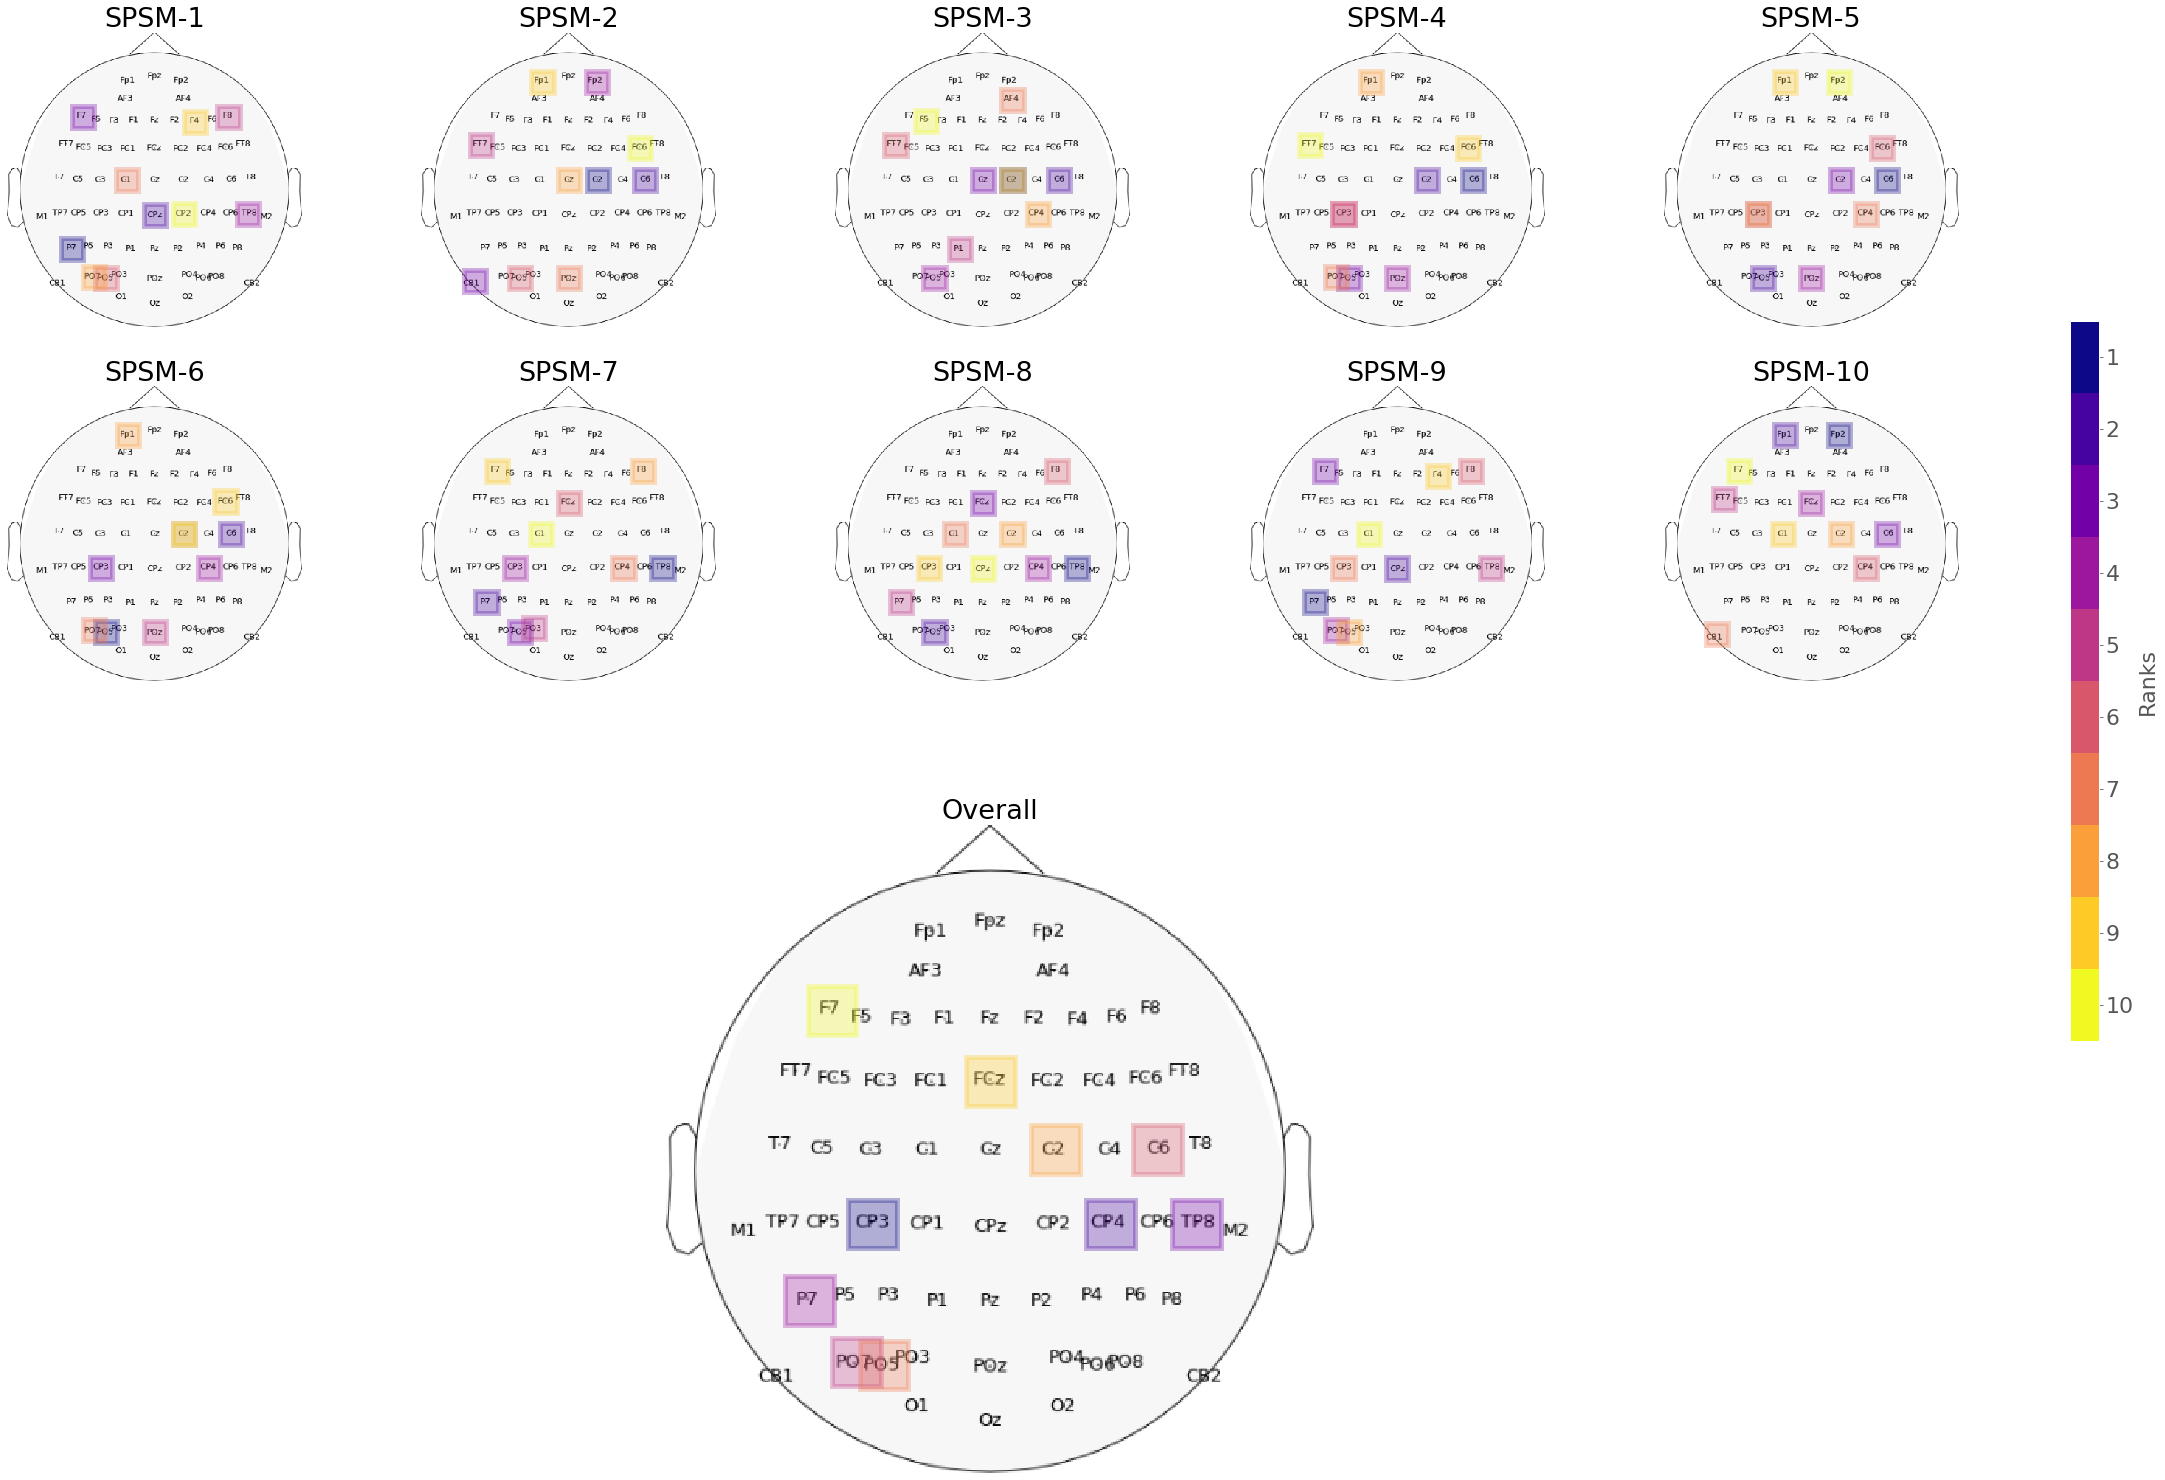

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(40,20))

axes = axes.flatten()

for i,id in enumerate(model_ids):
    viz_spatial_saliency(model_scs[id], pos, id, channels, axes[i])
    
overall_spsm_scs = normalize(overall_spsm_scs / 10)
    
fig.subplots_adjust(bottom=0.4)
ax = fig.add_axes([0.3, -0.15, 0.35, 0.45])
viz_spatial_saliency(overall_spsm_scs, pos, 'Overall', channels, ax)
    
fig.subplots_adjust(right=0.82, top=0.85)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.5])

cmap = mpl.cm.plasma_r
ticks = [str(i+1) for i in range(10)]
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm,
                                orientation='vertical', ticklocation='right', 
                                values=np.linspace(0,1,10), ticks=np.linspace(0,1,10))

cb1.set_label('Ranks', fontdict={'size': 22})
cb1.ax.set_yticklabels(ticks[::-1])

plt.show()

slow : [' C6' ' CP3' ' CP3' ' CP4' ' C2' ' PO5' ' C1' ' C3' ' POz' ' PO3' ' PO7'
 ' F5' ' TP8' ' FCz' ' F8' ' CP2' ' P7' ' CB1' ' PO5' ' F7']
med : [' CP3' ' CP4' ' P7' ' TP8' ' PO7' ' PO5' ' C2' ' C6' ' FCz' ' F7' ' PO5'
 ' CPz' ' C1' ' F8' ' POz' ' PO3' ' C2' ' F5' ' FC1' ' O1']
fast : [' CP3' ' TP8' ' P7' ' CP4' ' PO5' ' PO7' ' C6' ' F7' ' C2' ' FCz' ' F8'
 ' PO5' ' PO3' ' C1' ' CPz' ' FC1' ' POz' ' CP2' ' Fp2' ' Fp1']


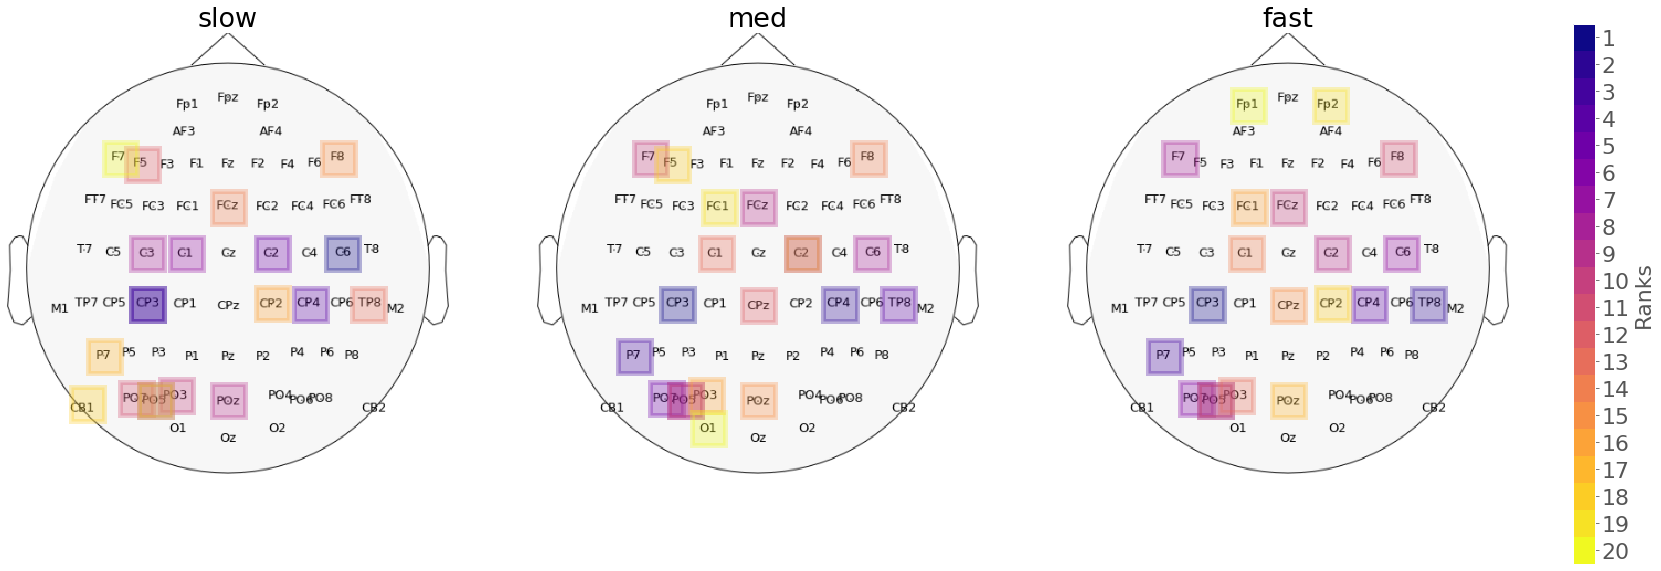

In [10]:
slow_i_range = [0, n_slow]
med_i_range = [n_slow, n_slow + n_med]
fast_i_range = [n_slow + n_med, n_slow + n_med + n_fast]

slow = overall_spsm_scs[:slow_i_range[1]]
med = overall_spsm_scs[med_i_range[0]: med_i_range[1]]
fast = overall_spsm_scs[fast_i_range[0]: fast_i_range[1]]

scs = [slow, med, fast]

fig, axes = plt.subplots(ncols=3, figsize=(30,15))

axes = axes.flatten()

rt_class = ['slow', 'med', 'fast']

for i, sc in enumerate(scs):
    viz_spatial_saliency(sc, pos, rt_class[i], channels, axes[i], 20)
    
fig.subplots_adjust(right=0.82, top=0.85)
cbar_ax = fig.add_axes([0.85, 0.2, 0.01, 0.5])

cmap = mpl.cm.plasma_r
ticks = [str(i+1) for i in range(20)]
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm,
                                orientation='vertical', ticklocation='right', 
                                values=np.linspace(0,1,20), ticks=np.linspace(0,1,20))

cb1.set_label('Ranks', fontdict={'size': 22})
cb1.ax.set_yticklabels(ticks[::-1])

plt.show()

## Visualize Spectral Saliency for all SPSMs

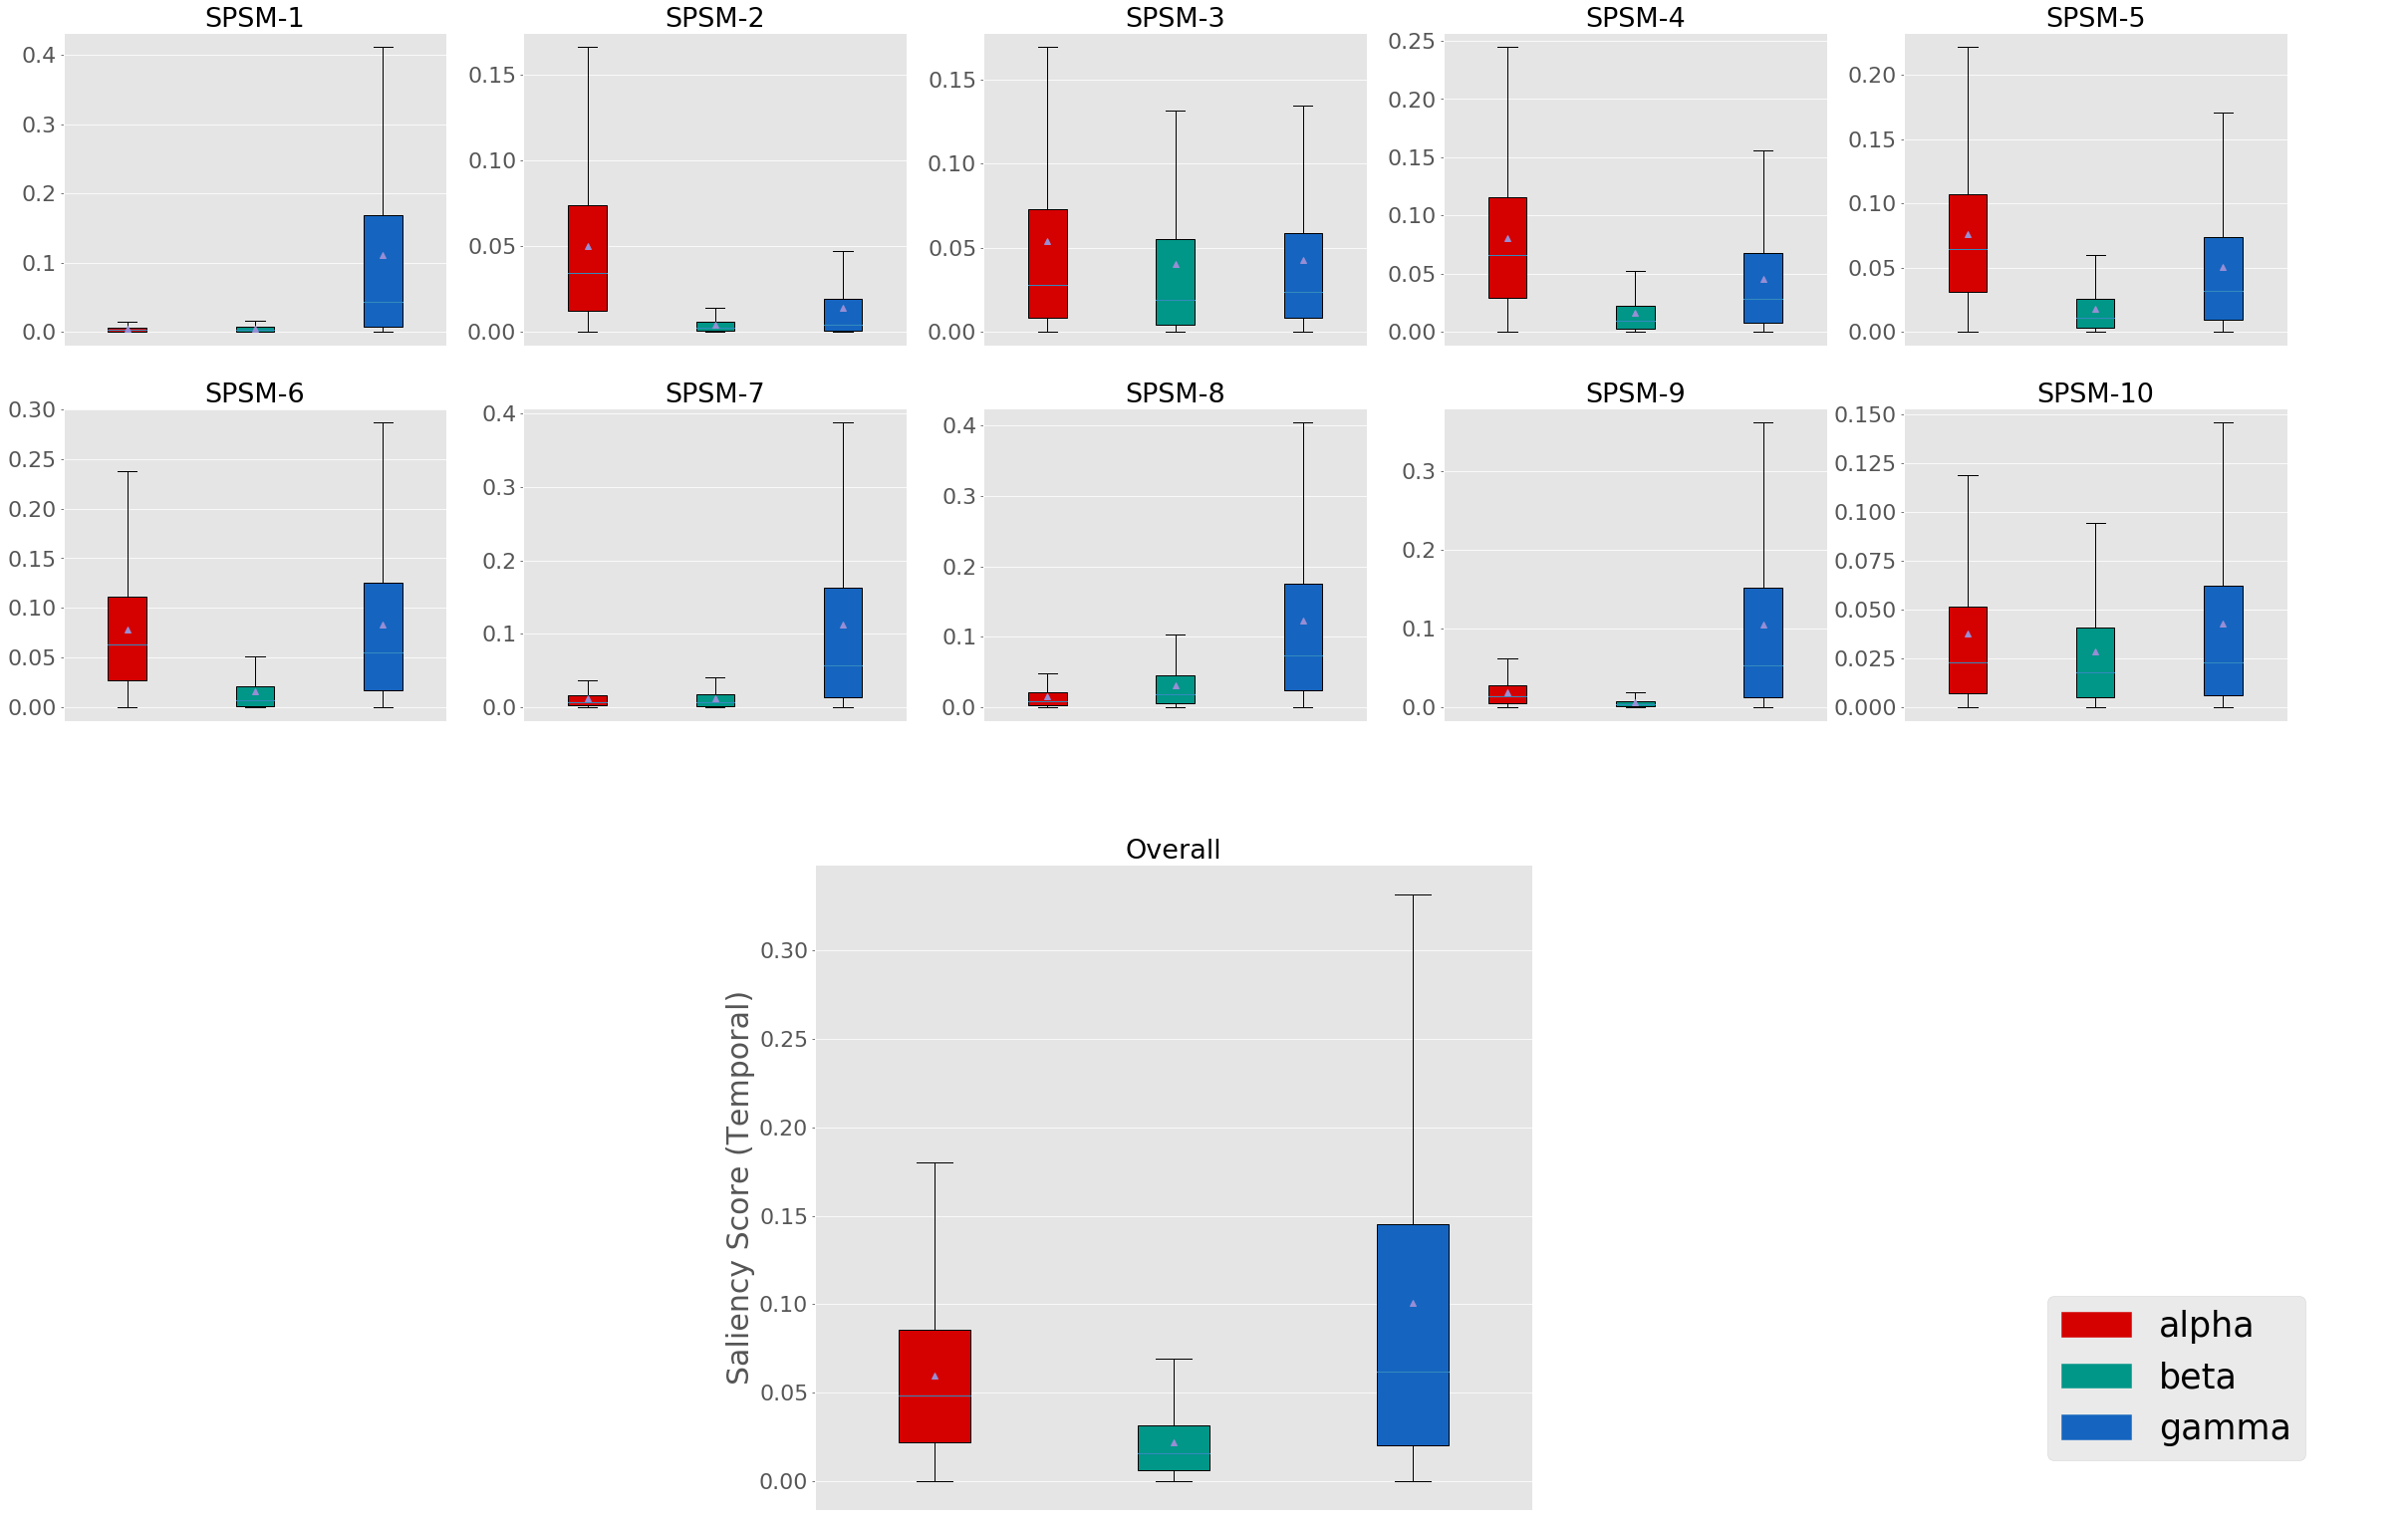

In [66]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(40,20))

axes = axes.flatten()

for i,id in enumerate(model_ids):
    viz_spectral_saliency(model_scs[id], id, axes[i])
    
# overall_spec_scs = normalize(overall_spec_scs / 10)

fig.subplots_adjust(bottom=0.4)
ax = fig.add_axes([0.387, -0.15, 0.25, 0.45])
ax = viz_spectral_saliency(overall_spsm_scs, 'Overall', ax)
ax.set_ylabel('Saliency Score (Temporal)', fontdict={'size':30})
alpha_patch = mpatches.Patch(color="#d50000", label='alpha')
beta_patch = mpatches.Patch(color="#009688", label='beta')
gamma_patch = mpatches.Patch(color="#1565C0", label='gamma')
fig.legend(handles=[alpha_patch, beta_patch, gamma_patch], loc=(0.85,0.04))
plt.show()

### Store Spectral Saliency for ANOVA

In [67]:
overall_spec_scs = np.mean(overall_spsm_scs.reshape(-1,64,3), axis=1)
slow_g = np.array(n_slow * ['slow']).reshape((-1, 1))
med_g = np.array(n_med * ['med']).reshape((-1, 1))
fast_g = np.array(n_fast * ['fast']).reshape((-1, 1))

subjects = pd.read_csv("data/sub_test_rt_50.csv")

groups = np.vstack((slow_g, med_g, fast_g))

data_spectral_sm = pd.DataFrame(overall_spec_scs, columns=['alpha', 'beta', 'gamma'])

data_spectral_sm.insert(0, 'group', groups)
data_spectral_sm.insert(1, 'subs', subjects['subs'])

df_melt = pd.melt(data_spectral_sm, id_vars=['group', 'subs'], value_vars=['alpha', 'beta', 'gamma'])
df_melt.columns = ['groups', 'subs', 'bands', 'saliency']

df_melt.to_csv("ANOVA/Overall_Spectral_Saliency.csv")
df_melt.groupby(['subs', 'groups']).mean()

saliency
subs groups          
N1   fast    0.014519
     med     0.017590
     slow    0.015085
N10  fast    0.015449
     med     0.014276
...               ...
T8   med     0.016168
     slow    0.015919
T9   fast    0.013088
     med     0.016448
     slow    0.016010

[150 rows x 1 columns]

In [66]:
all_spec_scs = model_scs['SPSM-1']
subs = subjects['subs']
model_ids = np.array(len(all_spec_scs) * ['SPSM-1'])
for i,id in tqdm(enumerate(model_scs)):
    if i == 0:
        continue
    all_spec_scs = np.vstack((all_spec_scs, model_scs[id]))
    
    slow_g = np.array(n_slow * ['slow']).reshape((-1, 1))
    med_g = np.array(n_med * ['med']).reshape((-1, 1))
    fast_g = np.array(n_fast * ['fast']).reshape((-1, 1))
    
    groups = np.vstack((groups, slow_g, med_g, fast_g))
    
    model_ids = np.append(model_ids, len(model_scs[id]) * [id])
    
    subs = np.append(subs, subjects['subs'])
    
all_spec_scs = np.mean(all_spec_scs.reshape((-1,64,3)), axis=1)
data_spectral_sm = pd.DataFrame(all_spec_scs, columns=['alpha', 'beta', 'gamma'])

data_spectral_sm.insert(0, 'group', groups)
data_spectral_sm.insert(1, 'subs', subs.reshape((-1, 1)))
data_spectral_sm.insert(2, 'model', model_ids.reshape((-1,1)))

df_melt = pd.melt(data_spectral_sm, id_vars=['group', 'subs', 'model'], value_vars=['alpha', 'beta', 'gamma'])
df_melt.columns = ['groups', 'subs', 'model', 'bands', 'saliency']
df_melt.to_csv("ANOVA/Spectral_Saliency_all_SPSMs.csv")
df_melt.groupby(['model']).mean()

saliency
model            
SPSM-1   0.009871
SPSM-10  0.007938
SPSM-2   0.010213
SPSM-3   0.007026
SPSM-4   0.012049
SPSM-5   0.010894
SPSM-6   0.011791
SPSM-7   0.011661
SPSM-8   0.011313
SPSM-9   0.013748

In [63]:
df_melt.groupby(['subs', 'groups', 'model'])

bands  saliency
subs groups model                   
N1   fast   SPSM-1   gamma  0.137720
            SPSM-10  gamma  0.057761
            SPSM-2   gamma  0.089907
            SPSM-3   gamma  0.040286
            SPSM-4   gamma  0.069308
...                    ...       ...
T9   slow   SPSM-5   gamma  0.059548
            SPSM-6   gamma  0.068290
            SPSM-7   gamma  0.103632
            SPSM-8   gamma  0.070861
            SPSM-9   gamma  0.128533

[1500 rows x 2 columns]

### Store Spatial Saliency for ANOVA analysis

In [95]:
overall_spatial_scs = np.max(overall_spsm_scs.reshape(-1,64,3), axis=2)
slow_g = np.array(n_slow * ['slow']).reshape((-1, 1))
med_g = np.array(n_med * ['med']).reshape((-1, 1))
fast_g = np.array(n_fast * ['fast']).reshape((-1, 1))

subjects = pd.read_csv("data/sub_test_rt_50.csv")

groups = np.vstack((slow_g, med_g, fast_g))

data_spatial_sm = pd.DataFrame(overall_spatial_scs, columns=channels)

data_spatial_sm.insert(0, 'group', groups)
data_spatial_sm.insert(1, 'subs', subjects['subs'])


df_melt = pd.melt(data_spatial_sm, id_vars=['group', 'subs'], value_vars=channels)
df_melt.columns = ['groups', 'subs', 'channels', 'saliency']
df_melt.to_csv("ANOVA/Overall_Spatial_Saliency.csv")
df_melt.groupby(['groups', 'subs', 'channels']).mean().count()

saliency    9600
dtype: int64

In [96]:
all_spatial_scs = model_scs['SPSM-1']
subs = subjects['subs']
model_ids = np.array(len(all_spatial_scs) * ['SPSM-1'])
for i,id in tqdm(enumerate(model_scs)):
    if i == 0:
        continue
    all_spatial_scs = np.vstack((all_spatial_scs, model_scs[id]))
    
    slow_g = np.array(n_slow * ['slow']).reshape((-1, 1))
    med_g = np.array(n_med * ['med']).reshape((-1, 1))
    fast_g = np.array(n_fast * ['fast']).reshape((-1, 1))
    
    groups = np.vstack((groups, slow_g, med_g, fast_g))
    
    model_ids = np.append(model_ids, len(model_scs[id]) * [id])
    
    subs = np.append(subs, subjects['subs'])
    
all_spatial_scs = np.max(all_spatial_scs.reshape((-1,64,3)), axis=2)
data_spatial_sm = pd.DataFrame(all_spatial_scs, columns=channels)

data_spatial_sm.insert(0, 'group', groups)
data_spatial_sm.insert(1, 'subs', subs.reshape((-1, 1)))
data_spatial_sm.insert(2, 'model', model_ids.reshape((-1,1)))

df_melt = pd.melt(data_spatial_sm, id_vars=['group', 'subs', 'model'], value_vars=channels)
df_melt.columns = ['groups', 'subs', 'model', 'channels', 'saliency']
df_melt.to_csv("ANOVA/Spatial_Saliency_all_SPSMs.csv")
df_melt.groupby(['groups', 'subs', 'model', 'channels']).count()

saliency
groups subs model  channels          
fast   N1   SPSM-1  AF3            95
                    AF4            95
                    C1             95
                    C2             95
                    C3             95
...                               ...
slow   T9   SPSM-9  Pz             62
                    T7             62
                    T8             62
                    TP7            62
                    TP8            62

[96000 rows x 1 columns]